In [ ]:
# https://stackoverflow.com/questions/48641189/fitting-3d-data-as-input-into-keras-sequential-model-layer

In [ ]:
!pip install qhoptim
!conda install keras=2.3.1 -y

In [2]:
# Use only CPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [14]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc

#keras
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, AveragePooling1D, GlobalAveragePooling1D

from tensorflow.keras.layers import Conv2D, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle5 as pickle
# 
# from qhoptim.tf import QHAdamOptimizer

In [3]:
# small old ../datasets/AMPsNonAMPs_df.239.plk
# /home/ubuntu/data/AMPsNonAMPs_df.plk old dataset
# /mnt/vdb/thesis/jax/AMPNonAMP.final.reps new dataset

with open( "/mnt/vdb/thesis/jax/AMPNonAMP.V5_C08_sim60.reps", 'rb') as file:
    AMPs_df = pickle.load(file)

In [2]:
# For PWS
with open( '/mnt/vdb/thesis/pwm/AMPnonAMP.sim60_c08.pwm.pkl', 'rb') as file:
    AMPs_df = pickle.load(file)


In [ ]:
#AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df =AMPs_df[AMPs_df["length"] <=30 ]
AMPs_df 

### Utility function: plot_history, display_model_score

In [3]:
def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  test_score = model.evaluate(test[0], test[1], verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

In [18]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    print(' Learning rate: ', lr)    
    return lr 

# Split Train/ Test / Validation set

In [4]:
AMPs_df.shape

(137389, 400)

In [52]:
# For PWM -400 dimension
window_sizes = 20

X = AMPs_df[:,0:window_sizes*20].reshape(len(AMPs_df),1,20,window_sizes)
Y = np.array([0] * 68869 + [1] * 68520) # <-- change here
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [4]:
#X= np.array(AMPs_df['reps'].to_list())
#y= np.array(AMPs_df['class'].to_list())

X_train, X_test, y_train, y_test = train_test_split(np.array(AMPs_df['reps'].to_list()),  np.array(AMPs_df['class'].to_list()), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [53]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  82433
Val size:  27478
Test size:  27478


## Custom CNN

In [6]:
# 3d dimension for LSTM
# Batchs, n_timesteps, n_features

# Images 3d dimension
# width , heigth , channel

# Conv1D with sequential data
# batch, steps, channels

# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(128565, 1900, 1)
(42856, 1900, 1)
(42855, 1900, 1)


In [7]:
X_train

array([[[ 0.05368484, -0.03313179, -0.04137151, ...,  0.04686536,
          0.07515805,  0.09453979]],

       [[ 0.01226678,  0.03930363,  0.02485003, ...,  0.03290013,
          0.0553586 , -0.03752161]],

       [[ 0.02220141, -0.0530687 ,  0.0117378 , ...,  0.06830079,
          0.13145781,  0.03153091]],

       ...,

       [[ 0.01613748,  0.0919472 ,  0.07108982, ...,  0.05503492,
         -0.02092175,  0.02752282]],

       [[ 0.00737427, -0.02503035,  0.03058322, ..., -0.04634462,
          0.13963404,  0.00552622]],

       [[ 0.01309069,  0.00857742,  0.03156777, ...,  0.05718511,
          0.09086805, -0.00191969]]])

In [13]:
X_train.shape[1]

1

In [12]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

ValueError: cannot reshape array of size 156622700 into shape (82433,1,1)

In [7]:
# the best Mark I
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    conv = Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)

    # Flatten NN
    flat = Flatten()(conv)
    
    layer_3 = Dense(2432, activation='relu')(flat)
    dropout_3 = Dropout(0.5)(layer_3)
    layer_4 = Dense(1211, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.5)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="RMSprop", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 512)         4096      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 633, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 633, 256)          655616    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 316, 256)          0         
_________________________________________________________________
flatten (Flatten)            (None, 80896)             0         
_________________________________________________________________
dense (Dense)                (None, 1211)             

In [58]:
# n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], 1
# nn.Conv1d with a kernel size of 1 and nn.Linear   give exactly the same results.

# use in dev 

#SGD
#RMSprop
#Adam
#Adadelta
#Adagrad
#Adamax
#Nadam
#Ftrl
#
#
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    #conv = Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu')(x_input) 
    #conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(512, kernel_size=8, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=3)(conv)
    dropout_3 = Dropout(0.5)(layer_3)
    conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)
    dropout_3 = Dropout(0.5)(layer_3)
   
    # Flatten NN
    flat = Flatten()(conv)
    layer_3 = Dense(1211, activation='relu')(flat)
    dropout_3 = Dropout(0.2)(layer_3)
    layer_4 = Dense(1211, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.2)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1900, 512)         4608      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 633, 512)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 633, 256)          655616    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 316, 256)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 80896)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1211)            

In [19]:
# create_ModelII
## https://github.com/p-koo/learning_sequence_motifs/blob/master/code/models/cnn_25.py show best here 
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
  #bn1 = BatchNormalization()(data)
  #act1 = Activation('relu')(bn1)
    
    conv = Conv1D(128, kernel_size=19, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)
    
    x = BatchNormalization()(conv)
   
    # Flatten NN
    flat = Flatten()(x)
    layer_3 = Dense(1211, activation='relu')(flat)
    dropout_3 = Dropout(0.5)(layer_3)
    layer_4 = Dense(512, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.5)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1900, 128)         2560      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 76, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 76, 128)           82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 19, 128)           512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2432)             

In [ ]:
# https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras

In [13]:
# create_ModelIIII
#

def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
        
    conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)
    
    x = BatchNormalization()(conv)
    x = Flatten()(x)
    #output = GlobalMaxPooling1D()(x)
    
    output = Dense(2432, activation=None)(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Dense(1216, activation=None)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(output)
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1900, 64)          2624      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 76, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 128)           57472     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 128)           512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2432)             

In [21]:
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/CustomCNN.Adam.v4.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(X_train, y_train, epochs=100,
                    batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[es, lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
645/645 [==============================] - 8s 13ms/step - loss: 0.3627 - accuracy: 0.8438 - val_loss: 0.4580 - val_accuracy: 0.7969
 Learning rate:  0.001
Epoch 2/100
645/645 [==============================] - 8s 12ms/step - loss: 0.2875 - accuracy: 0.8804 - val_loss: 0.3460 - val_accuracy: 0.8559
 Learning rate:  0.001
Epoch 3/100
645/645 [==============================] - 8s 12ms/step - loss: 0.2612 - accuracy: 0.8932 - val_loss: 0.3036 - val_accuracy: 0.8721
 Learning rate:  0.001
Epoch 4/100
645/645 [==============================] - 7s 12ms/step - loss: 0.2425 - accuracy: 0.9011 - val_loss: 0.2612 - val_accuracy: 0.8937
 Learning rate:  0.001
Epoch 5/100
645/645 [==============================] - 8s 12ms/step - loss: 0.2296 - accuracy: 0.9075 - val_loss: 0.3445 - val_accuracy: 0.8735
 Learning rate:  0.001
Epoch 6/100
645/645 [==============================] - 8s 12ms/step - loss: 0.2215 - accuracy: 0.9099 - val_loss: 0.2718 - val_accuracy: 0.892

In [25]:
model.save('/mnt/vdb/thesis/CustomCNN.Adam.III.V5.h5') 

In [22]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

2577/2577 [==============================] - 6s 2ms/step - loss: 0.0143 - accuracy: 0.9968
Train loss:  0.014292317442595959
Train accuracy:  0.9968095421791077
----------------------------------------------------------------------
859/859 [==============================] - 2s 2ms/step - loss: 0.3717 - accuracy: 0.9305
Val loss:  0.3716603219509125
Val accuracy:  0.9305262565612793
----------------------------------------------------------------------
859/859 [==============================] - 2s 2ms/step - loss: 0.4053 - accuracy: 0.9254
Test loss:  0.40525904297828674
Test accuracy:  0.9253948330879211


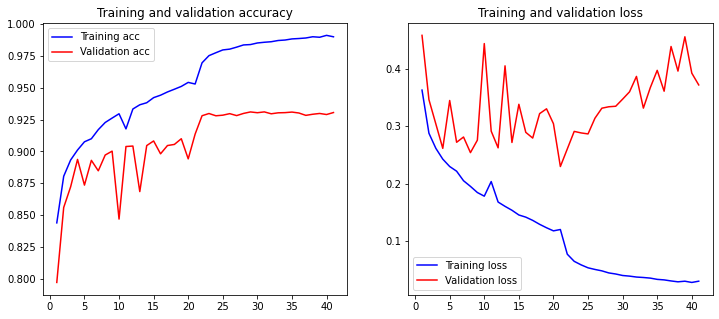

In [23]:
plot_history(history)

In [24]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     13856
           1       0.92      0.93      0.92     13622

    accuracy                           0.93     27478
   macro avg       0.93      0.93      0.93     27478
weighted avg       0.93      0.93      0.93     27478



In [12]:
# Markk III
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     21596
           1       0.94      0.95      0.95     21260

    accuracy                           0.95     42856
   macro avg       0.95      0.95      0.95     42856
weighted avg       0.95      0.95      0.95     42856



In [ ]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

In [20]:
# 11/3/2021
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     22886
           1       0.95      0.91      0.93     22400

    accuracy                           0.93     45286
   macro avg       0.94      0.93      0.93     45286
weighted avg       0.93      0.93      0.93     45286



In [62]:
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     25564
           1       0.96      0.95      0.95     25244

    accuracy                           0.95     50808
   macro avg       0.95      0.95      0.95     50808
weighted avg       0.95      0.95      0.95     50808



# PWM 

## 2D Conv

In [ ]:
# https://github.com/khanhlee/snare-cnn/blob/master/snare_classification.py

num_features = 400
nb_classes = 2
nb_kernels = 3
nb_pools = 2

def cnn_model():
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1), input_shape = (1,20,window_sizes)))
    model.add(Conv2D(32, (nb_kernels, nb_kernels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pools, nb_pools), data_format="channels_first"))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (nb_kernels, nb_kernels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pools, nb_pools), data_format="channels_first"))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (nb_kernels, nb_kernels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pools, nb_pools), data_format="channels_first"))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (nb_kernels, nb_kernels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pools, nb_pools), data_format="channels_first"))

    #model.add(Conv2D(32, (nb_kernels, nb_kernels), padding="same", input_shape=(1,20,window_sizes)))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(strides=(nb_pools, nb_pools), data_format="channels_first"))
    
    #model.add(Conv2D(64, (nb_kernels, nb_kernels), padding="same" ))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(strides=(nb_pools, nb_pools), data_format="channels_first"))
    
    #model.add(Conv2D(128, (nb_kernels, nb_kernels), padding="same"))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(strides=(nb_pools, nb_pools), data_format="channels_first"))

    #model.add(Conv2D(256, (nb_kernels, nb_kernels), padding="same"))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(strides=(nb_pools, nb_pools), data_format="channels_first"))

    ## add the model on top of the convolutional base
    #model.add(top_model)
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(256))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))

    model.add(  Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001)))
    #model.add(BatchNormalization())

    # f = open('model_summary.txt','w')
    # f.write(str(model.summary()))
    # f.close()

    #model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = cnn_model()
#model.summary()

In [95]:
# Mark III
def create_Modelbaseline():
    x_input = Input(shape=(1,20,window_sizes)) # n_timesteps, n_features
        
    conv = Conv2D(64, kernel_size=(5,5), strides=(1,1) , padding='same', activation='relu', data_format="channels_first")(x_input)  # Extract whole motif pattern
    conv = MaxPooling2D(pool_size=(2,2), strides=(1,1) , data_format="channels_first") (conv)
    conv = Conv2D(128, kernel_size=(3,3), strides=(1,1)  , padding='same', activation='relu', data_format="channels_first")(conv)  # Extract extra features  
    conv = MaxPooling2D(pool_size=(2,2) , strides=(1,1)  , data_format="channels_first")(conv)
    
    x = BatchNormalization()(conv)
    x = Flatten()(x)
    #output = GlobalMaxPooling1D()(x)
    
    output = Dense(1000, activation=None)(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Dense(512, activation=None)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(output)
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 20, 20)]       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 64, 20, 20)        1664      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 64, 19, 19)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 128, 19, 19)       73856     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 128, 18, 18)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 18, 18)       72        
_________________________________________________________________
flatten_18 (Flatten)         (None, 41472)            

In [96]:

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

## balance data
history = model.fit(X_train, y_train, epochs=100,
                    batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[es, lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
645/645 [==============================] - 7s 11ms/step - loss: 0.5055 - accuracy: 0.7669 - val_loss: 0.4115 - val_accuracy: 0.8144
 Learning rate:  0.001
Epoch 2/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3977 - accuracy: 0.8252 - val_loss: 0.3720 - val_accuracy: 0.8417
 Learning rate:  0.001
Epoch 3/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3623 - accuracy: 0.8447 - val_loss: 0.3477 - val_accuracy: 0.8500
 Learning rate:  0.001
Epoch 4/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3407 - accuracy: 0.8551 - val_loss: 0.3420 - val_accuracy: 0.8538
 Learning rate:  0.001
Epoch 5/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3223 - accuracy: 0.8652 - val_loss: 0.3201 - val_accuracy: 0.8641
 Learning rate:  0.001
Epoch 6/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3057 - accuracy: 0.8727 - val_loss: 0.3111 - val_accuracy: 0.872

In [97]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

2577/2577 [==============================] - 5s 2ms/step - loss: 0.0524 - accuracy: 0.9843
Train loss:  0.052420176565647125
Train accuracy:  0.9843388199806213
----------------------------------------------------------------------
859/859 [==============================] - 2s 2ms/step - loss: 0.3067 - accuracy: 0.9069
Val loss:  0.3066624402999878
Val accuracy:  0.906907320022583
----------------------------------------------------------------------
859/859 [==============================] - 2s 2ms/step - loss: 0.3040 - accuracy: 0.9078
Test loss:  0.3039868474006653
Test accuracy:  0.9077807664871216


In [98]:
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     13820
           1       0.90      0.92      0.91     13658

    accuracy                           0.91     27478
   macro avg       0.91      0.91      0.91     27478
weighted avg       0.91      0.91      0.91     27478



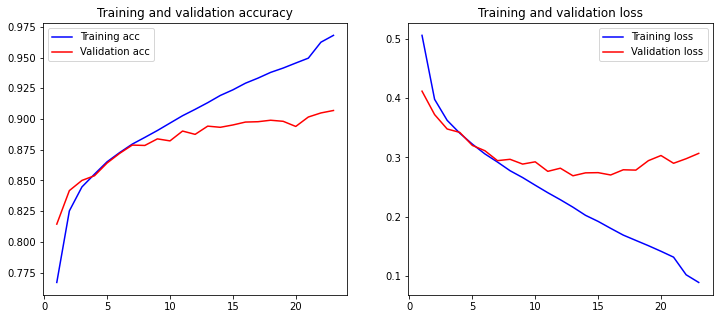

In [99]:
plot_history(history)

In [100]:
model.save('/mnt/vdb/thesis/CustomCNN.Adam.V6.h5')

# Conclusion

In [ ]:
# IF you AveragePooling in any -> didn;t show the good performance so use Maxpooling 
# 1211 , 512 show the better performance  

# 2 CNN layer
# 2 Dense layer 

# Add

In [19]:
model.layers_by_depth

AttributeError: 'Functional' object has no attribute 'layers_by_depth'